## 03 — Parameter Estimation

This notebook performs parameter estimation using synthetic radio science observations, as generated in Notebook 02.

The goal is to estimate selected dynamical parameters from simulated one-way range measurements between the Juno spacecraft and a ground station on Earth.

Main steps includes: Define estimable parameters; Configure estimation input; Run least-squares estimation; Analyse estimation residuals and covariance

#### - Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tudatpy.interface import spice
from tudatpy import dynamics
from tudatpy.dynamics import environment_setup, propagation_setup, parameters_setup
from tudatpy import estimation
from tudatpy.estimation import observable_models_setup, observations_setup, estimation_analysis
from tudatpy.estimation.observable_models_setup import links, model_settings
from tudatpy.estimation.observable_models_setup.links import LinkEndType
from tudatpy.estimation.observable_models_setup.model_settings import one_way_range, ObservableType
from tudatpy.astro import element_conversion
from tudatpy import constants
from tudatpy.astro.time_representation import DateTime
from tudatpy.util import result2array

#### - Define SPICE Kernels and Simulation Epoch

In [2]:
spice.load_standard_kernels()

simulation_start_epoch = DateTime(2016, 10, 5).to_epoch()
propagation_start_epoch = simulation_start_epoch - 3600.0
simulation_end_epoch = simulation_start_epoch + 2*24*3600
propagation_end_epoch = simulation_end_epoch + 3600.0

#### - Create Dynamical Environment and Ground Station

In [3]:
bodies_to_create = ["Sun","Jupiter","Earth"]

global_frame_origin = "Jupiter"
global_frame_orientation = "ECLIPJ2000"

body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation
)

body_settings.add_empty_settings("Juno")

body_settings.get("Juno").constant_mass = 2e3  #2000 kg

jupiter_gravitational_parameter = constants.GRAVITATIONAL_CONSTANT * 1.898e27  

semi_major_axis = 1.07e9
eccentricity = 0.95
inclination = np.deg2rad(90.0)
argument_of_periapsis = np.deg2rad(0.0)
longitude_of_ascending_node = np.deg2rad(0.0)
true_anomaly = np.deg2rad(0.0)

keplerian_elements = [
    semi_major_axis,
    eccentricity,
    inclination,
    argument_of_periapsis,
    longitude_of_ascending_node,
    true_anomaly
]

juno_ephemeris_settings = environment_setup.ephemeris.keplerian(
    keplerian_elements,
    propagation_start_epoch,
    jupiter_gravitational_parameter,
    global_frame_origin,
    global_frame_orientation
)

reference_area_radiation = 50.0  # m²
radiation_pressure_coefficient = 1.2
occulting_bodies_dict = {"Sun": ["Jupiter", "Earth"]}

body_settings.get("Juno").radiation_pressure_target_settings = (
    environment_setup.radiation_pressure.cannonball_radiation_target(
        reference_area_radiation,
        radiation_pressure_coefficient,
        occulting_bodies_dict
    )
)

bodies = environment_setup.create_system_of_bodies(body_settings)

In [4]:
dss14_altitude = 1071.0
dss14_latitude = np.deg2rad(35.4269)
dss14_longitude = np.deg2rad(243.1105)

environment_setup.add_ground_station(
    bodies.get_body("Earth"),
    "DSS-14",
    np.array([dss14_altitude, dss14_latitude, dss14_longitude])
)

#### - Define Observation Link

In [5]:
link_ends = dict()

link_ends[LinkEndType.transmitter] = (
    links.body_origin_link_end_id("Juno")
)

link_ends[LinkEndType.receiver] = (
    links.body_reference_point_link_end_id("Earth","DSS-14")
)

link_definition = links.LinkDefinition(link_ends)

In [6]:
observable_settings = [
    one_way_range(link_definition)
]

#### - Generate Observation Times and Simulators

In [7]:

observation_times = np.arange(
    simulation_start_epoch,
    simulation_end_epoch,
    60.0
)

In [8]:

observation_simulators = observations_setup.observations_simulation_settings.create_observation_simulators(
    observable_settings,
    bodies
)

In [32]:
simulation_settings = observations_setup.observations_simulation_settings.tabulated_simulation_settings(
    observable_models_setup.model_settings.ObservableType.one_way_range_type,
    link_definition,
    observation_times
)

#### - Define Acceleration Models

In [10]:

spacecraft_name = "Juno"

acceleration_settings = {
    spacecraft_name : {
        "Jupiter":[propagation_setup.acceleration.point_mass_gravity()],
        "Sun":[propagation_setup.acceleration.point_mass_gravity()]
    }
}

In [11]:

acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    [spacecraft_name],
    ["Jupiter"]
)

#### - Initial State and Propagation Settings

In [12]:

initial_state = element_conversion.keplerian_to_cartesian(
    keplerian_elements,
    jupiter_gravitational_parameter
)

In [13]:

termination_settings = propagation_setup.propagator.time_termination(
    simulation_end_epoch
)

termination_settings = propagation_setup.propagator.time_termination(
    simulation_end_epoch
)

integrator_settings = propagation_setup.integrator.runge_kutta_4(
    propagation_start_epoch,
    60.0
)

In [14]:

propagator_settings = propagation_setup.propagator.translational(
    ["Jupiter"],
    acceleration_models,
    [spacecraft_name],
    initial_state,
    propagation_start_epoch,
    integrator_settings,
    termination_settings
)

#### - Define Estimable Parameters and Create Estimation Input


In [15]:
parameter_settings = dynamics.parameters_setup.initial_states(
    propagator_settings,
    bodies
)

parameters_to_estimate = parameters_setup.create_parameter_set(
    parameter_settings,
    bodies
)

dynamics.parameters_setup.create_parameter_set(
    parameter_settings,
    bodies
)

In [16]:
estimator = estimation_analysis.Estimator(
    bodies,
    parameters_to_estimate,
    observable_settings,
    propagator_settings
)

In [36]:
observations = observations_setup.observations_wrapper.simulate_observations(
    [simulation_settings],
    estimator.observation_simulators,
    bodies
)

In [18]:

estimation_input = estimation.estimation_analysis.EstimationInput(
    observations
)

estimation_input.define_estimation_settings(
    reintegrate_variational_equations=True
)

estimation_output = estimator.perform_estimation(
    estimation_input
)

#### - Run Least Squares Estimation


In [19]:

estimator = estimation_analysis.Estimator(
    bodies,
    parameters_to_estimate,
    observable_settings,
    propagator_settings
)

estimation_output = estimator.perform_estimation(
    estimation_input
)

simulated_observations = observations_setup.observations_wrapper.simulate_observations(
    [simulation_settings],
    estimator.observation_simulators,
    bodies)

#### - Extract and plot Residuals

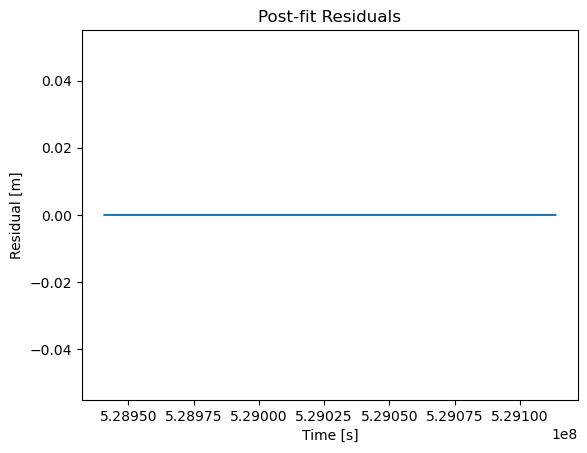

In [25]:
residuals = estimation_output.final_residuals.flatten()
observation_times = observations.concatenated_times

plt.figure()
plt.plot(observation_times, residuals)
plt.xlabel("Time [s]")
plt.ylabel("Residual [m]")
plt.title("Post-fit Residuals")
plt.show()


#### - Covariance Analysis and Formal Errors

In [26]:
covariance = estimation_output.covariance

print("Covariance Matrix:")
print(covariance)

Covariance Matrix:
[[ 4.25439020e+00 -1.79783062e+01 -2.82655916e+01  3.93744882e-02
  -4.95959601e-01 -2.74858011e-03]
 [-1.79783063e+01  8.03654578e+01  1.31470387e+02 -1.80732060e-01
   2.24190783e+00  1.16111995e-02]
 [-2.82655919e+01  1.31470387e+02  2.20781766e+02 -3.00950566e-01
   3.69585034e+00  1.82508081e-02]
 [ 3.93744886e-02 -1.80732060e-01 -3.00950565e-01  4.11391201e-04
  -5.06891253e-03 -2.54258427e-05]
 [-4.95959605e-01  2.24190784e+00  3.69585033e+00 -5.06891253e-03
   6.27000177e-02  3.20293154e-04]
 [-2.74858011e-03  1.16111994e-02  1.82508079e-02 -2.54258424e-05
   3.20293151e-04  1.77574386e-06]]


In [27]:
formal_errors = np.sqrt(np.diag(covariance))

print("Formal Errors:")
print(formal_errors)

Formal Errors:
[2.06261732e+00 8.96467834e+00 1.48587269e+01 2.02827809e-02
 2.50399716e-01 1.33257040e-03]


## Conclusion

There is no residue evident in the plot, as we are just simulating a dynamic model, without introducing noise for now. In the next notebook, we will evaluate the sensitivity of the method.

The covariance and formal error are small, in agreement with the simulation scenario without external interference.